<a href="https://colab.research.google.com/github/helonayala/sysid/blob/main/narx_frols_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NARX Model Identification, Estimation, and Simulation using FROLS

This script provides a comprehensive framework for working with power-form polynomials **N**onlinear **A**uto**R**egressive models with e**X**ogenous Inputs (**NARX**). It leverages polynomial basis functions to capture system nonlinearities and employs the **F**orward-**R**egression **O**rthogonal **L**east **S**quares (**FROLS**) algorithm for robust model structure identification and parameter estimation from time-series data.

**Key Components and Functionalities:**

1.  **Polynomial NARX Representation:**
    * The script automatically generates the set of candidate regressors. These include lagged versions of the system output (`y`) and exogenous input (`u`), as well as their polynomial cross-products up to a user-defined degree (`l`).

2.  **FROLS Algorithm for Model Building:**
    * FROLS iteratively selects the most significant terms from the candidate regressor set according to the ERR metric, leading to a parsimonious model structure.

3.  **Scikit-learn Style `NARX` Class:**
    * To promote ease of use and integration, a Python class named `NARX` is defined. It follows a familiar scikit-learn style formalism for model construction and interaction:
        * **Initialization (`__init__`)**: Allows users to specify crucial model hyperparameters such as input lags (`nu`), output lags (`ny`), the maximum polynomial order (`poly_order_l`), and the FROLS error reduction ratio threshold (`rho_threshold`) for term selection.
        * **Fitting (`fit` method)**: Trains the NARX model using provided input (`u`) and output (`y`) data. This method internally orchestrates regressor generation and the FROLS procedure to determine the model structure and parameters.
        * **Prediction (`predict` method)**: Offers versatile prediction capabilities:
            * **One-Step-Ahead (OSA) Prediction**: Predicts the system's output for the next time step using all available actual past measurements of `y` and `u`.
            * **Free-Run (FR) Simulation**: Simulates the system's output iteratively over multiple future time steps. In this mode, only initial conditions for `y` and the sequence of future `u` are used; past *predicted* `y` values are fed back as inputs to the model. A progress bar is included for monitoring longer simulations.

4.  **End-to-End Example Workflow:**
    * The script includes a practical demonstration:
        * **Data Simulation:** Generates sample data from a known nonlinear dynamic system, providing a testbed for the NARX modeling approach.
        * **Model Instantiation and Training:** Shows how to create an instance of the `NARX` class and fit it to the simulated data.
        * **Prediction and Validation:** Illustrates how to perform both OSA predictions and FR simulations, and visualizes the model's performance by comparing its outputs against the actual system data.


## Imports, functions, and classes

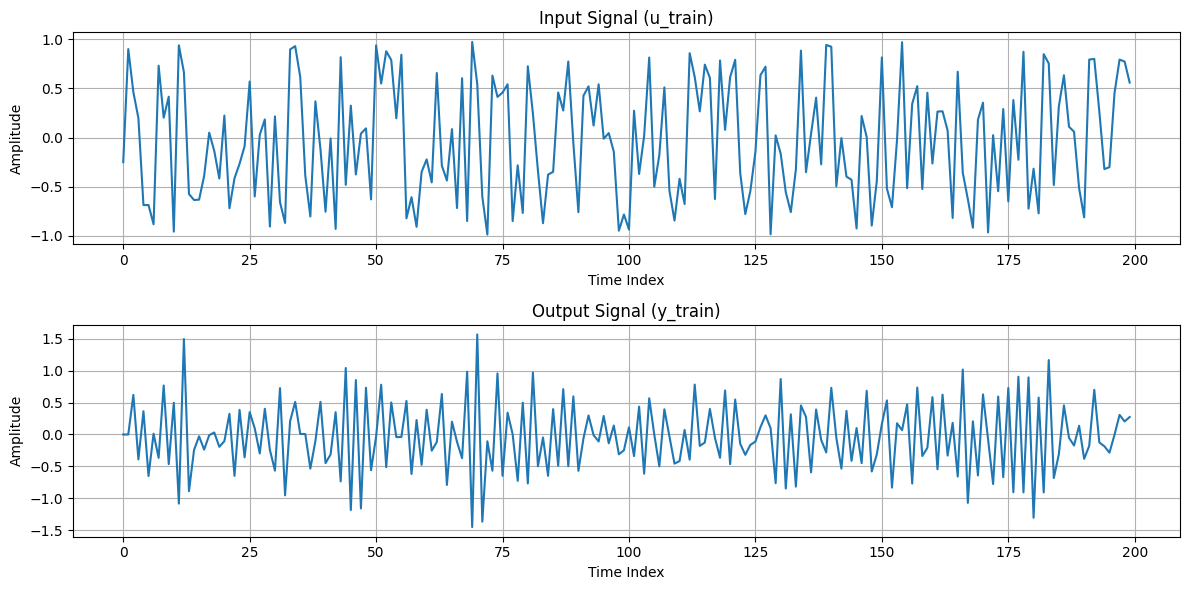

In [ ]:
import numpy as np
from itertools import combinations_with_replacement
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm # tqdm.auto will select the best bar for console/notebook

# --- Function: regMatARX ---
def regMatARX(y_signal_in,
              u_signal_in,
              ny: int,
              nu: int):
    """
    Creates the initial ARX regression matrix and the target vector y(k).
    AR (y-lag) terms are NOT negated.

    Args:
        y_signal_in (array-like): Output data vector.
        u_signal_in (array-like): Input data vector.
        ny (int): Number of past y lags (autoregressive order).
        nu (int): Number of past u lags (exogenous input order).

    Returns:
        P0_data (np.ndarray): The ARX regressor matrix. Shape (NP, ny + nu).
        P0_colnames (list): Column names for P0_data.
        y_target (np.ndarray): The target vector y(k). Shape (NP,).
    """
    if not isinstance(y_signal_in, np.ndarray):
        y_signal = np.array(y_signal_in, dtype=float)
    else:
        y_signal = y_signal_in.astype(float)

    if not isinstance(u_signal_in, np.ndarray):
        u_signal = np.array(u_signal_in, dtype=float)
    else:
        u_signal = u_signal_in.astype(float)

    if len(y_signal) != len(u_signal):
        raise ValueError("Input signals y_signal and u_signal must have the same length.")
    if ny < 0 or nu < 0:
        raise ValueError("Lags ny and nu must be non-negative.")

    N_total_samples = len(y_signal)

    max_lag = 0
    if ny > 0: max_lag = max(max_lag, ny)
    if nu > 0: max_lag = max(max_lag, nu)

    y_target = y_signal[max_lag:]
    num_effective_rows = len(y_target)

    P0_colnames = []
    if ny > 0: P0_colnames.extend([f'y(k-{i})' for i in range(1, ny + 1)])
    if nu > 0: P0_colnames.extend([f'u(k-{i})' for i in range(1, nu + 1)])
    num_P0_cols = len(P0_colnames)

    if num_effective_rows == 0:
        return np.empty((0, num_P0_cols), dtype=float), P0_colnames, np.empty((0,), dtype=float)

    P0_rows_list = []
    for k_target_idx in range(max_lag, N_total_samples):
        current_regressor_row = []
        for j_lag_idx in range(1, ny + 1):
            current_regressor_row.append(y_signal[k_target_idx - j_lag_idx])
        for j_lag_idx in range(1, nu + 1):
            current_regressor_row.append(u_signal[k_target_idx - j_lag_idx])
        P0_rows_list.append(current_regressor_row)
    P0_data = np.array(P0_rows_list, dtype=float)
    return P0_data, P0_colnames, y_target

# --- Function: regMatNARX ---
def regMatNARX(u_signal_in,
               y_signal_in,
               nu: int,
               ny: int,
               poly_order_l: int):
    """
    Generates the full candidate regression matrix for a NARX model
    and the corresponding target vector y(k).
    """
    if not isinstance(y_signal_in, np.ndarray): y_signal = np.array(y_signal_in, dtype=float)
    else: y_signal = y_signal_in.astype(float)
    if not isinstance(u_signal_in, np.ndarray): u_signal = np.array(u_signal_in, dtype=float)
    else: u_signal = u_signal_in.astype(float)

    if len(y_signal) != len(u_signal): raise ValueError("Signals must have same length.")
    if ny < 0 or nu < 0: raise ValueError("Lags must be non-negative.")
    if poly_order_l < 1: raise ValueError("Polynomial order l must be at least 1.")

    P0_data, P0_colnames, y_target = regMatARX(y_signal, u_signal, ny, nu)
    NP = len(y_target) # Number of effective rows (can be 0)

    if NP > 0:
        P_columns_list = [np.ones((NP, 1), dtype=float)] # Constant term
    else:
        P_columns_list = [np.empty((0, 1), dtype=float)] # Constant term for 0 rows

    P_final_colnames = ['constant']
    P_columns_list.append(P0_data)
    P_final_colnames.extend(P0_colnames)
    num_P0_base_regressors = P0_data.shape[1]

    if poly_order_l >= 2 and num_P0_base_regressors > 0:
        for current_poly_order in range(2, poly_order_l + 1):
            for col_indices_tuple in combinations_with_replacement(range(num_P0_base_regressors), current_poly_order):
                term_name = "".join([P0_colnames[i] for i in col_indices_tuple])
                P_final_colnames.append(term_name)
                if NP > 0: # Only compute values if there are rows
                    selected_P0_cols = P0_data[:, list(col_indices_tuple)]
                    new_poly_term_col = np.prod(selected_P0_cols, axis=1, keepdims=True)
                    P_columns_list.append(new_poly_term_col)
                # If NP=0, P_columns_list will keep (0,k) arrays, and P_final_colnames grows.
                # np.concatenate will correctly form a (0, total_cols) matrix.

    if NP == 0: # If no rows, ensure all appended arrays in P_columns_list are (0, N_cols)
        # P_columns_list might contain P0_data (0,k_P0) and constant (0,1).
        # Polynomial terms if poly_order_l >=2 are only added to P_final_colnames if NP=0.
        # We need to create empty columns for these polynomial terms if they were named.
        # Current P_columns_list: [(0,1)_const, (0,k_P0)_P0_data]
        # P_final_colnames: [const, P0_names..., Poly_names...]
        # We need to add empty columns for Poly_names to P_columns_list before concatenate.

        # Number of polynomial terms added only to colnames if NP=0:
        num_poly_terms_in_colnames = len(P_final_colnames) - len(P_columns_list[0].T) - P0_data.shape[1]

        # This is a bit tricky; let's simplify the construction of P_final_data
        # if NP == 0, it must be an empty matrix with the correct number of total columns.
        total_cols = len(P_final_colnames)
        P_final_data = np.empty((0, total_cols), dtype=float)
    else: # NP > 0
        P_final_data = np.concatenate(P_columns_list, axis=1)

    return P_final_data, P_final_colnames, y_target

# --- Function: frols_py ---
def frols_py(P_regressors, Y_target_in, rho, P_colnames=None, epsilon=1e-12):
    """
    Forward Orthogonal Least Squares algorithm for model term selection and parameter estimation.
    """
    if Y_target_in.ndim == 1:
        Y_target = Y_target_in.reshape(-1, 1)
    else:
        Y_target = Y_target_in

    M = P_regressors.shape[1]
    NP = P_regressors.shape[0]
    empty_result = {
        'th': np.array([]), 'Psel_data': np.empty((NP,0)), 'Psel_colnames': [],
        'g': np.array([]), 'W': np.empty((NP,0)), 'A': np.empty((0,0)),
        'ERR_values': np.array([]), 'selected_indices': []}
    if NP == 0 or M == 0: return empty_result

    sig_yy_val = (Y_target.T @ Y_target).item();
    if sig_yy_val < epsilon: sig_yy_val = epsilon

    selected_terms_indices = []; err_selected_list = []; g_selected_list = []
    Q_orthogonal_bases = np.empty((NP, 0)); A_matrix = np.empty((0,0))
    M0 = 0

    for s_term_iter in range(M):
        current_ERRs = np.full(M, -np.inf); current_gs = np.zeros(M)
        current_Qs_storage = np.zeros((NP, M))

        if s_term_iter == 0:
            for m_idx in range(M):
                p_m = P_regressors[:, m_idx:m_idx+1]; p_m_norm_sq = (p_m.T @ p_m).item()
                if p_m_norm_sq >= epsilon:
                    current_Qs_storage[:,m_idx] = p_m.flatten()
                    current_gs[m_idx] = (Y_target.T @ p_m).item() / p_m_norm_sq
                    current_ERRs[m_idx] = (current_gs[m_idx]**2 * p_m_norm_sq) / sig_yy_val
        else:
            for m_idx in range(M):
                if m_idx in selected_terms_indices: continue
                p_m = P_regressors[:, m_idx:m_idx+1]; q_m_orth = p_m.copy()
                for r_q_idx in range(M0):
                    q_r = Q_orthogonal_bases[:, r_q_idx:r_q_idx+1]; q_r_norm_sq = (q_r.T @ q_r).item()
                    alpha_mr = 0.0
                    if q_r_norm_sq >= epsilon: alpha_mr = (p_m.T @ q_r).item() / q_r_norm_sq
                    q_m_orth -= alpha_mr * q_r
                current_Qs_storage[:,m_idx] = q_m_orth.flatten()
                q_m_orth_norm_sq = (q_m_orth.T @ q_m_orth).item()
                if q_m_orth_norm_sq >= epsilon:
                    current_gs[m_idx] = (Y_target.T @ q_m_orth).item() / q_m_orth_norm_sq
                    current_ERRs[m_idx] = (current_gs[m_idx]**2 * q_m_orth_norm_sq) / sig_yy_val

        if np.all(np.isneginf(current_ERRs)): break
        newly_selected_idx = np.argmax(current_ERRs)
        selected_terms_indices.append(newly_selected_idx)
        err_selected_list.append(current_ERRs[newly_selected_idx])
        g_selected_list.append(current_gs[newly_selected_idx])
        Q_selected_term = current_Qs_storage[:, newly_selected_idx:newly_selected_idx+1]
        Q_orthogonal_bases = Q_selected_term if Q_orthogonal_bases.shape[1] == 0 else np.hstack((Q_orthogonal_bases, Q_selected_term))

        p_orig_new_sel = P_regressors[:, newly_selected_idx:newly_selected_idx+1]
        if M0 == 0: A_matrix = np.array([[1.0]])
        else:
            A_new_col = np.zeros((M0, 1))
            for r_A_idx in range(M0):
                q_r_for_A = Q_orthogonal_bases[:, r_A_idx:r_A_idx+1]
                q_r_for_A_norm_sq = (q_r_for_A.T @ q_r_for_A).item()
                if q_r_for_A_norm_sq >= epsilon:
                    A_new_col[r_A_idx, 0] = (p_orig_new_sel.T @ q_r_for_A).item() / q_r_for_A_norm_sq
            A_matrix = np.block([[A_matrix, A_new_col],[np.zeros((1, M0)), np.array([[1.0]])]])
        M0 += 1
        if (1.0 - np.sum(err_selected_list)) <= rho: break

    if M0 == 0: return empty_result
    A_final = A_matrix; g_final = np.array(g_selected_list).reshape(-1, 1)
    theta_FROLS = np.linalg.solve(A_final, g_final) if A_final.size > 0 and A_final.shape[0] == A_final.shape[1] else np.array([])
    if theta_FROLS.size == 0 and A_final.size > 0 : # If solve failed or matrix not square
        try: # Fallback for safety, though solve should work for well-formed A
            theta_FROLS = np.linalg.pinv(A_final) @ g_final
        except: # Catch all exceptions from pinv if A_final is really problematic
             theta_FROLS = np.array([])


    P_sel_data = P_regressors[:, selected_terms_indices]
    P_sel_colnames = [P_colnames[i] for i in selected_terms_indices] if P_colnames else []
    return {'th': theta_FROLS.flatten(), 'Psel_data': P_sel_data, 'Psel_colnames': P_sel_colnames,
            'g': g_final.flatten(), 'W': Q_orthogonal_bases, 'A': A_final,
            'ERR_values': np.array(err_selected_list).flatten(), 'selected_indices': selected_terms_indices}

# --- Class: NARX ---
class NARX:
    def __init__(self, nu: int, ny: int, poly_order_l: int, rho_threshold: float = 0.01):
        self.nu = nu
        self.ny = ny
        self.poly_order_l = poly_order_l
        self.rho_threshold = rho_threshold

        self.theta_ = None
        self.selected_P_colnames_ = None
        self.selected_indices_ = None
        self.P_candidate_colnames_ = None

        self._P0_colnames_base_ = []
        if self.ny > 0: self._P0_colnames_base_.extend([f'y(k-{i})' for i in range(1, self.ny + 1)])
        if self.nu > 0: self._P0_colnames_base_.extend([f'u(k-{i})' for i in range(1, self.nu + 1)])
        self._num_P0_base_regressors_ = len(self._P0_colnames_base_)
        self._max_lag_internal_ = max(self.ny, self.nu) if self.ny > 0 or self.nu > 0 else 0
        self.fit_results_ = None

    def fit(self, u_train, y_train):
        u_train_np = np.asarray(u_train, dtype=float)
        y_train_np = np.asarray(y_train, dtype=float)

        P_cand_matrix, self.P_candidate_colnames_, y_target_train = regMatNARX(
            u_train_np, y_train_np, self.nu, self.ny, self.poly_order_l
        )

        frols_results = frols_py(
            P_cand_matrix, y_target_train, self.rho_threshold, self.P_candidate_colnames_
        )

        self.theta_ = frols_results['th']
        self.selected_P_colnames_ = frols_results['Psel_colnames']
        self.selected_indices_ = frols_results['selected_indices']
        self.fit_results_ = frols_results

        if self.theta_ is None or len(self.theta_) == 0:
            print("Warning: FROLS did not select any terms or failed to estimate parameters.")
        return self

    def _form_single_candidate_row_values(self, current_y_lags_list, current_u_lags_list):
        current_P0_values = []
        if self.ny > 0: current_P0_values.extend(current_y_lags_list)
        if self.nu > 0: current_P0_values.extend(current_u_lags_list)

        all_terms_this_row_dict = {'constant': 1.0}
        for i in range(self._num_P0_base_regressors_):
            all_terms_this_row_dict[self._P0_colnames_base_[i]] = current_P0_values[i]

        if self.poly_order_l >= 2 and self._num_P0_base_regressors_ > 0:
            for current_order_poly in range(2, self.poly_order_l + 1):
                for p0_indices_tuple in combinations_with_replacement(range(self._num_P0_base_regressors_), current_order_poly):
                    term_name = "".join([self._P0_colnames_base_[j] for j in p0_indices_tuple])
                    term_val = np.prod([current_P0_values[j] for j in p0_indices_tuple])
                    all_terms_this_row_dict[term_name] = term_val

        full_candidate_row_ordered_list = []
        if self.P_candidate_colnames_ is None:
            raise RuntimeError("P_candidate_colnames_ not set. Model might not be fitted correctly.")

        for name in self.P_candidate_colnames_:
            val = all_terms_this_row_dict.get(name)
            if val is None:
                print(f"Warning: Term '{name}' not found in generated row dict for FR prediction. Using 0.0. This may indicate an issue.")
                full_candidate_row_ordered_list.append(0.0)
            else:
                full_candidate_row_ordered_list.append(val)
        return np.array(full_candidate_row_ordered_list)

    def predict(self, u_inputs, y_history_for_lags_or_osa=None, mode='OSA'):
        if self.theta_ is None or len(self.theta_) == 0:
            raise RuntimeError("Model has not been fitted or no terms were selected. Call fit() first.")

        u_inputs_np = np.asarray(u_inputs, dtype=float)
        if y_history_for_lags_or_osa is not None:
            y_hist_np = np.asarray(y_history_for_lags_or_osa, dtype=float)

        if mode == 'OSA':
            if y_history_for_lags_or_osa is None:
                raise ValueError("For OSA prediction, y_history_for_lags_or_osa (actual y values) must be provided.")

            P_osa_full, P_osa_full_colnames, y_target_osa = regMatNARX(
                u_inputs_np, y_hist_np, self.nu, self.ny, self.poly_order_l
            )

            if P_osa_full.shape[0] == 0 :
                return np.array([]), y_target_osa

            if list(P_osa_full_colnames) != list(self.P_candidate_colnames_):
                 print("Warning: OSA prediction column names differ from training. This might lead to issues if order varies subtly.")

            P_selected_osa = P_osa_full[:, self.selected_indices_]
            y_hat_osa = P_selected_osa @ self.theta_
            return y_hat_osa, y_target_osa

        elif mode == 'FR':
            if y_history_for_lags_or_osa is None:
                raise ValueError("For FR simulation, y_history_for_lags_or_osa (initial y conditions) must be provided.")

            y_initial_conditions = y_hist_np

            if len(y_initial_conditions) < self._max_lag_internal_:
                raise ValueError(f"Not enough initial y conditions for FR. Need {self._max_lag_internal_}, got {len(y_initial_conditions)}")

            num_total_timeline_points = len(u_inputs_np)
            if num_total_timeline_points < self._max_lag_internal_ and self._max_lag_internal_ > 0 :
                 print("Warning: u_inputs not long enough for FR simulation start. Returning empty.")
                 return np.array([])

            y_hat_fr_full = np.zeros(num_total_timeline_points)

            if self._max_lag_internal_ > 0:
                y_hat_fr_full[:self._max_lag_internal_] = y_initial_conditions[:self._max_lag_internal_]

            # --- Progress bar added here ---
            simulation_range = range(self._max_lag_internal_, num_total_timeline_points)
            num_sim_steps = num_total_timeline_points - self._max_lag_internal_

            print(f"Starting Free-Run Simulation for {num_sim_steps} steps...")
            for k_pred_idx in tqdm(simulation_range, desc="FR Simulation", unit="step", total=num_sim_steps):
                current_y_lags = []
                if self.ny > 0:
                    current_y_lags = [y_hat_fr_full[k_pred_idx - j] for j in range(1, self.ny + 1)]

                current_u_lags = []
                if self.nu > 0:
                    current_u_lags = [u_inputs_np[k_pred_idx - j] for j in range(1, self.nu + 1)]

                full_candidate_row = self._form_single_candidate_row_values(current_y_lags, current_u_lags)
                selected_regressors_for_row = full_candidate_row[self.selected_indices_]

                y_hat_fr_full[k_pred_idx] = selected_regressors_for_row @ self.theta_

            return y_hat_fr_full[self._max_lag_internal_:]
        else:
            raise ValueError(f"Unknown prediction mode: {mode}. Choose 'OSA' or 'FR'.")


## Generate synthetic data

In [ ]:
N_data = 200
np.random.seed(42)
u_sim_data = np.random.uniform(low=-1, high=1, size=N_data)
e_sim_noise = np.random.normal(loc=0, scale=0.1, size=N_data)
y_sim_data = np.zeros(N_data)

for k_idx in range(2, N_data):
    y_sim_data[k_idx] = (
        -0.605 * y_sim_data[k_idx-1]
        - 0.163 * (y_sim_data[k_idx-2]**2)
        + 0.588 * u_sim_data[k_idx-1]
        - 0.24 * u_sim_data[k_idx-2]
        + e_sim_noise[k_idx]
    )
u_train = u_sim_data
y_train = y_sim_data

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(u_train)
plt.title('Input Signal (u_train)')
plt.xlabel('Time Index')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(y_train)
plt.title('Output Signal (y_train)')
plt.xlabel('Time Index')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

## Define model parameters, call constructor, and run estimation

In [ ]:
rho_frols_thresh = 0.03
nu_model = 2
ny_model = 2
poly_order_model = 3

# 3. Instantiate and fit the NARX model
narx_model = NARX(nu=nu_model, ny=ny_model, poly_order_l=poly_order_model, rho_threshold=rho_frols_thresh)
narx_model.fit(u_train, y_train)

print("--- Fitted NARX Model ---")
if narx_model.theta_ is not None and len(narx_model.theta_) > 0:
    print(f"Max lag internal (_max_lag_internal_): {narx_model._max_lag_internal_}")
    print("\nSelected terms & parameters (theta):")
    for i, term_name in enumerate(narx_model.selected_P_colnames_):
        print(f"  {i+1}. {term_name}: {narx_model.theta_[i]:.4f}")

    print("\nERR values for selected terms (%):")
    if narx_model.fit_results_['ERR_values'].size > 0:
        for i, err_val in enumerate(narx_model.fit_results_['ERR_values']):
            term_name = narx_model.selected_P_colnames_[i]
            print(f"  {term_name}: {err_val * 100:.2f}%")
    total_err_reduction = np.sum(narx_model.fit_results_['ERR_values']) * 100
    print(f"\nTotal ERR explained by selected terms: {total_err_reduction:.2f}%")
else:
    print("No terms were selected by FROLS, or fitting failed.")


--- Fitted NARX Model ---
Max lag internal (_max_lag_internal_): 2

Selected terms & parameters (theta):
  1. y(k-1): -0.6109
  2. u(k-1): 0.5782
  3. u(k-2): -0.2387
  4. y(k-2)y(k-2): -0.1496

ERR values for selected terms (%):
  y(k-1): 52.43%
  u(k-1): 38.11%
  u(k-2): 4.67%
  y(k-2)y(k-2): 1.86%

Total ERR explained by selected terms: 97.07%


## One-Step-Ahead (OSA) Prediction



--- One-Step-Ahead (OSA) Prediction ---


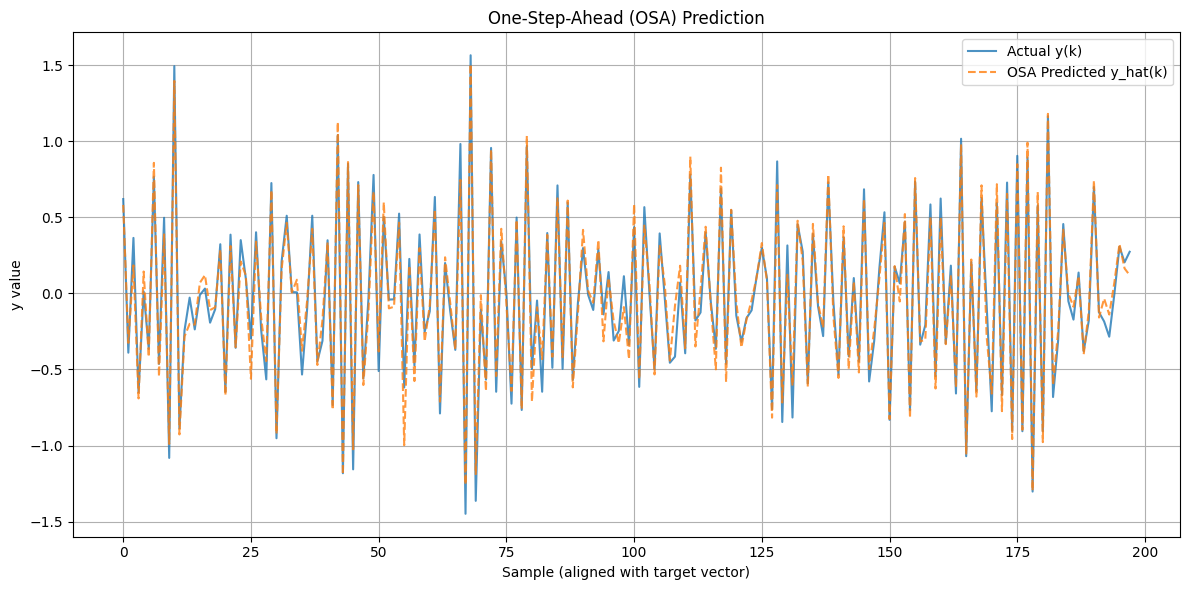

OSA Prediction MSE: 0.0094


In [ ]:
u_inputs_osa = u_train
y_history_osa = y_train
y_hat_osa, y_target_osa = narx_model.predict(u_inputs_osa, y_history_osa, mode='OSA')

plt.figure(figsize=(12, 6))
plt.plot(y_target_osa, label='Actual y(k)', alpha=0.8)
plt.plot(y_hat_osa, label='OSA Predicted y_hat(k)', linestyle='--', alpha=0.8)
plt.title('One-Step-Ahead (OSA) Prediction')
plt.xlabel('Sample (aligned with target vector)')
plt.ylabel('y value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
mse_osa = np.mean((y_target_osa - y_hat_osa)**2)
print(f"OSA Prediction MSE: {mse_osa:.4f}")

## Free-Run (FR) Simulation

Starting Free-Run Simulation for 198 steps...


FR Simulation:   0%|          | 0/198 [00:00<?, ?step/s]

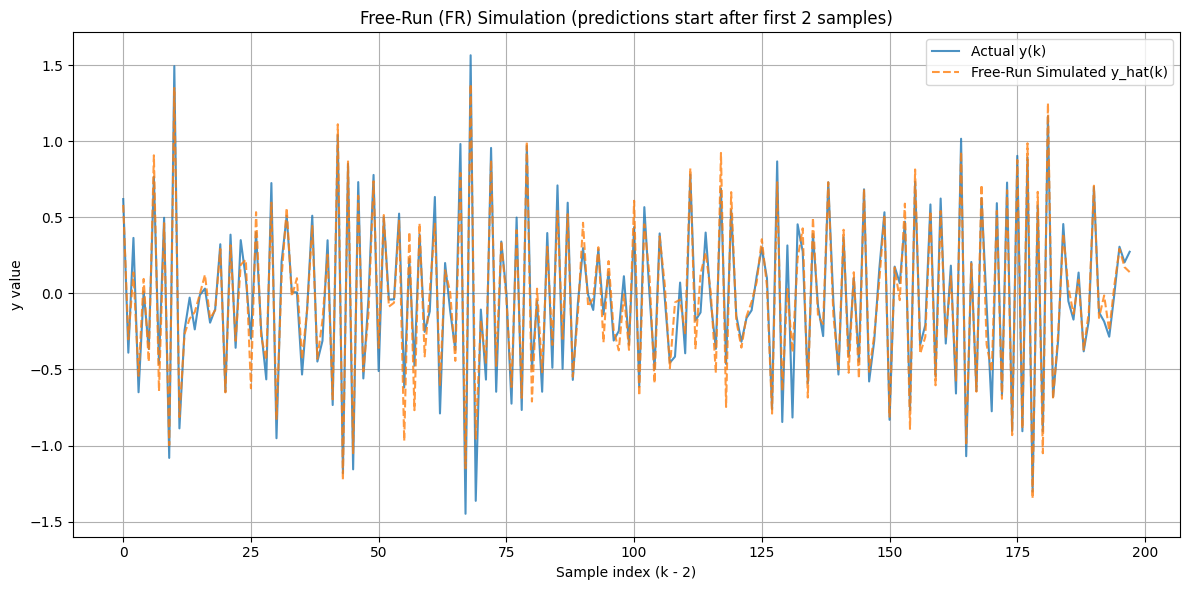

Free-Run Simulation MSE (on 198 points): 0.0154


In [ ]:
max_lag = narx_model._max_lag_internal_

y_initial_conditions_fr = y_train[:max_lag]
u_sequence_for_fr = u_train # u_train needs to be long enough, starting from u[0]

y_hat_fr = narx_model.predict(u_sequence_for_fr,
                              y_history_for_lags_or_osa=y_initial_conditions_fr,
                              mode='FR')

y_actual_for_fr_comparison = y_train[max_lag:] # Target for the FR part

# Ensure lengths match for plotting
min_len = min(len(y_hat_fr), len(y_actual_for_fr_comparison))

plt.figure(figsize=(12, 6))
plt.plot(y_actual_for_fr_comparison[:min_len], label='Actual y(k)', alpha=0.8)
plt.plot(y_hat_fr[:min_len], label='Free-Run Simulated y_hat(k)', linestyle='--', alpha=0.8)
plt.title(f'Free-Run (FR) Simulation (predictions start after first {max_lag} samples)')
plt.xlabel(f'Sample index (k - {max_lag})')
plt.ylabel('y value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
mse_fr = np.mean((y_actual_for_fr_comparison[:min_len] - y_hat_fr[:min_len])**2)

print(f"Free-Run Simulation MSE (on {min_len} points): {mse_fr:.4f}")
